Etat initial: Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.66345354 0.        ]
 [0.         0.33654646]]
100 100 100 100 100


C:\Users\corei5\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


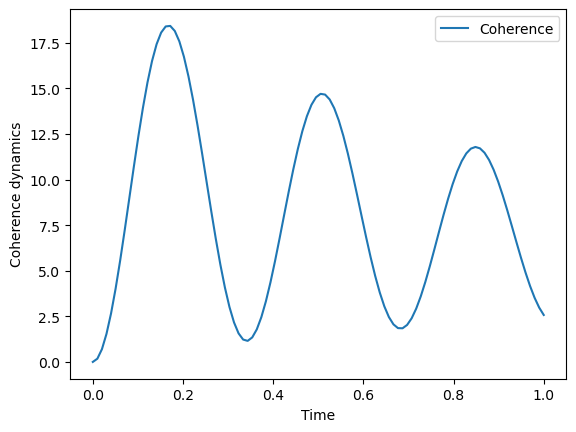

mean square error: 0.7830480425794668


"\nfig, ax=plt.subplots()\nax.plot(X_test[1], Y_test[1], linestyle='None', label='True Values <Sx>', color='blue', marker='+')\nax.plot(X_test[2], Y_test[2], linestyle='None', label='True Values <Sy>', color='orange', marker='+')\nax.plot(X_test[3], Y_test[3], linestyle='None', label='True Values <Sz>', color='green', marker='+')\nax.plot(X_test[1], Y_pred[1], linestyle='None', label ='Extrapolation values <Sx>', color='blue', marker='*')\nax.plot(X_test[2], Y_pred[2], linestyle='None', label ='Extrapolation values <Sy>', color='orange', marker='*')\nax.plot(X_test[3], Y_pred[3], linestyle='None', label ='Extrapolation values <Sz>', color='green', marker='*')\nax.set_xlabel('Test input value')\nax.set_ylabel('Test and predicted output expectation values')\nplt.legend()\nplt.show()\n\n#Tracer l'Historique d'apprentissage\nplt.plot(model.loss_curve_)\nplt.title('Learning history')\nplt.xlabel('Epoch')\nplt.ylabel('Loss')\nplt.show()\n\n###\n\n\n#Comparer la performence du modele avec le 

In [45]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jun  2 13:23:22 2023

@author: wilfried TADJEUGUE
"""

from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from numpy.random import rand
import numpy as np
from qutip import *
import matplotlib.pyplot as plt

# Definition des parametres du systeme
N = 7  # Nombre de spins

omega = 1  # Champ magnetique externe
gamma = 0.08  # Taux de decoherence
# Definition des operateurs de Paule
sx = sigmax()
sy = sigmay()
sz = sigmaz()

# Definition des operateurs de spins pour chaque site
sx_list = [tensor(sx, qeye(2**(N-1)))]*N
sy_list = [tensor(sy, qeye(2**(N-1)))]*N
sz_list = [tensor(sz, qeye(2**(N-1)))]*N

# Definition des projecteurs sur le spin-up pour chaque spin
n = [0.5*(tensor(qeye(2), qeye(2**(N-1))) + tensor(sz, qeye(2**(N-1))))]*N

# Definition du Hamiltonien

def H_obc(omega, V, alpha):
    # Hmiltonien du champ transversale
    H_0 = omega*sum(sx_list)

    # Hamiltonien d'interaction
    H_int = 0
    for i in range(N):
        for j in range(N):
            if i < j:
                H_int += (1/abs((i-j)**alpha)*n[i]*n[j])
    H_int = V*H_int
    H = H_0 + H_int
    return(H)
#print(H_obc(omega=1, V=0.3, alpha=10))


# Etat initial du systeme
a = np.random.uniform(0.01,0.7)
hro0_S = Qobj([[1-a,0],[0,a]])
# print(hro0_S)
hro0 = tensor(hro0_S, qeye(2**(N-1)))
print('Etat initial:',hro0_S)
#hro0 = tensor(Qobj([[0.52066722,0], [0, 0.59590664]]), qeye(2**(N-1)))

# Liste des operateurs de Lindblad
L = []
for i in range(N):
    L.append(np.sqrt(gamma)*(sx_list[i]))

# Liste des tems
tlist = np.linspace(0.0, 1.0, 100)

# Evaluation des valeurs a travert la fonction mesolve
H = H_obc(omega, V=2, alpha=15)
result = mesolve(H, hro0, tlist, L, [sx_list[5], sy_list[5], sz_list[5]],args=None, options=None, progress_bar=None, _safe_mode=True)

# Valeurs moyennes des operateurs de spins
msx = result.expect[0]
msy = result.expect[1]
msz = result.expect[2]

# Dimenssion des valeurs moyennes
msx = result.expect[0]
dim = msx.shape
#print("la dimenssion de cette matrice est:", dim)

'''
fig, ax = plt.subplots()
ax.plot(result.times, result.expect[0], label='<Sx>')
ax.plot(result.times, result.expect[1], label='<Sy>')
ax.plot(result.times, result.expect[2], label='<Sz>')
ax.set_xlabel('Time')
ax.set_ylabel('Expectation values')
plt.legend()
plt.show()'''

# MODELE DE PERCEPTRON MULTICOUCHE

# Importation des modules
from numpy.random import rand
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# Generation des donnees d'apprentissage du MLP

# Donnees d'entrees
tlistx = np.linspace(0, 1, 100)
resultx = mesolve(H, hro0, tlistx, L, [sx_list[5], sy_list[5], sz_list[5]],
                  args=None, options=None, progress_bar=None, _safe_mode=True)
X0 = resultx.expect[0]
X1 = resultx.expect[1] 
X2 = resultx.expect[2]
#print(X0.shape)
# Donnees de sortie
tlisty = np.linspace(0+0.02, 1, 100)
resulty = mesolve(H, hro0, tlisty, L, [sx_list[5], sy_list[5], sz_list[5]],
                  args=None, options=None, progress_bar=None, _safe_mode=True)
Y0 = resulty.expect[0]
Y1 = resulty.expect[1]
Y2 = resulty.expect[2]
#print(Y0.shape)
#print(X0,X1,X2)

#REDUCED STATE EVOLUTION

s0 = [0.5*qeye(2)]*100
s1, s2, s3 = [], [], []

for i in X0:
    s1.append(0.5*i*sx)
for j in X1:
    s2.append(0.5*j*sy)
for k in X2:
    s3.append(0.5*k*sz)
    
hro_s = []
trace = []
populations = []
for t in range(len(s0)):
    hro_s.append(s0[t] + s1[t] + s2[t] + s2[t])
    

print(len(s0), len(s1), len(s2), len(s3), len(hro_s))

for Hro_s in hro_s:
    trace.append(np.trace(Hro_s))
    populations.append(sum([Hro_s.data[i, j] for i in range(Hro_s.shape[0]) for j in range(Hro_s.shape[1]) if i != j]))
    
fig, ax = plt.subplots()
#ax.plot(result.times, trace, label='Population')
ax.plot(result.times, populations, label='Coherence')
ax.set_xlabel('Time')
ax.set_ylabel('Coherence dynamics')
plt.legend()
plt.show()

#total = sum(matrix[i][j] for i in range(len(matrix)) for j in range(len(matrix)) if i != j)



####
#print(X1[2])
#print(Y1[2])
####
X = np.transpose([np.ones(100), X0, X1, X2])  #Ensemble des donnee d'entree de formation
Y = np.transpose([np.ones(100), Y0, Y1, Y2])  #Ensemble des sorties relles

#Verrification des dimmenssions
#print(X.shape)
#print(Y.shape)


#Division de l'ensemble des donnees en donnees de formation et en donnees de test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 40, train_size = 60, random_state = None, shuffle=False, stratify = None)
#print(X_train.shape)
#print(Y_train.shape)
#print(X_test.shape)
#print(X_test.shape)


# Architechture neuronale du perceptron multicouche
model = MLPRegressor(hidden_layer_sizes =(100,100,100,100), activation='relu', solver='adam', alpha = 0.1)

#Apprentissage du modele avec l'ensemble des donnees d'apprentissage
model.fit(X_train, Y_train)

#Evaluation de la performence du modele avec l'ensemble des donnees de test
Y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
print('mean square error:', mse)
#print(Y_pred.shape)

#Valeux predicte pour chaque observable du systeme
Y_pred_X = Y_pred[:,1]
Y_pred_Y = Y_pred[:,2]
Y_pred_Z = Y_pred[:,3]
#print(Y_pred_X.shape)   #Verrification de la dimmenssion des valeurs predites pour le premier observable de spin

#Visualisation graphique des valeurs compratives
fig, ax = plt.subplots()
#Dynamique exacte
ax.plot(resulty.times, resultx.expect[0], label='<$\sigma_x$>', color='blue')
ax.plot(resulty.times, resultx.expect[1], label='<$\sigma_y$>', color='orange')
ax.plot(resulty.times, resultx.expect[2], label='<$\sigma_z$>', color='green')
#Apprentissage
ax.plot(resulty.times[0:60], X_train[:,1], linestyle='None', label='<$\sigma_x$>mod', color='blue', marker='*')
ax.plot(resulty.times[0:60], X_train[:,2], linestyle='None', label='<$\sigma_y$>mod', color='orange', marker='*')
ax.plot(resulty.times[0:60], X_train[:,3], linestyle='None', label='<$\sigma_z$>mod', color='green', marker='*')
#Extrapolation ou prediction
ax.plot(resulty.times[60:100], Y_pred_X, linestyle='None', color='blue', marker='*')
ax.plot(resulty.times[60:100], Y_pred_Y, linestyle='None', color='orange', marker='*')
ax.plot(resulty.times[60:100], Y_pred_Z, linestyle='None', color='green',marker='*')
ax.set_xlabel('Time')
ax.set_ylabel('Expectation values')
plt.legend()
plt.show()


'''
fig, ax=plt.subplots()
ax.plot(X_test[1], Y_test[1], linestyle='None', label='True Values <Sx>', color='blue', marker='+')
ax.plot(X_test[2], Y_test[2], linestyle='None', label='True Values <Sy>', color='orange', marker='+')
ax.plot(X_test[3], Y_test[3], linestyle='None', label='True Values <Sz>', color='green', marker='+')
ax.plot(X_test[1], Y_pred[1], linestyle='None', label ='Extrapolation values <Sx>', color='blue', marker='*')
ax.plot(X_test[2], Y_pred[2], linestyle='None', label ='Extrapolation values <Sy>', color='orange', marker='*')
ax.plot(X_test[3], Y_pred[3], linestyle='None', label ='Extrapolation values <Sz>', color='green', marker='*')
ax.set_xlabel('Test input value')
ax.set_ylabel('Test and predicted output expectation values')
plt.legend()
plt.show()

#Tracer l'Historique d'apprentissage
plt.plot(model.loss_curve_)
plt.title('Learning history')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

###


#Comparer la performence du modele avec le solveur mesolve
#error_x = mean_squared_error(Y_test, Y_pred)
#error_y = mean_squared_error(resulty.expect[1], Y_pred)
#error_z = mean_squared_error(resulty.expect[2], Y_pred)'''


In [2]:
#Etat du systeme reduit

hro_s = 1/2*(qeye(2) + X0*sigma_x() + X1*sigma_y() + X2*sigma_z())

NameError: name 'sigma_x' is not defined